In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import pygame
import sys
import time

pygame 2.5.1 (SDL 2.28.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# simulation settings
num_of_particles = 6000
range_value = 4000
gravity_force_multiplier = -0.016
momentum_value = 1
friction = 0.9

In [3]:
# training settings
lr = 0.0002
dset_size = 500000
batch_size = 4096 * 32
epochs = 100

In [4]:
GPU = torch.device("cuda")

x_values = (2 * range_value * torch.rand(num_of_particles, dtype=torch.float32, device=GPU) - range_value).view(-1, 1)
y_values = (2 * range_value * torch.rand(num_of_particles, dtype=torch.float32, device=GPU) - range_value).view(-1, 1)

world = torch.cat((x_values, y_values), dim=1)

In [5]:
def reset_world():
    global world
    
    x_values = (2 * range_value * torch.rand(num_of_particles, dtype=torch.float32, device=GPU) - range_value).view(-1, 1)
    y_values = (2 * range_value * torch.rand(num_of_particles, dtype=torch.float32, device=GPU) - range_value).view(-1, 1)

    world = torch.cat((x_values, y_values), dim=1)
    
    return world

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(num_of_particles * 2 * 2, num_of_particles * 2 * 2)
        self.fc2 = nn.Linear(num_of_particles * 2 * 2, num_of_particles * 2)
        self.fc3 = nn.Linear(num_of_particles * 2, num_of_particles * 2)
        self.fc4 = nn.Linear(num_of_particles * 2, num_of_particles * 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x

net = Net()
net.to(GPU)

KeyboardInterrupt: 

: 

In [ ]:
loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
def get_global_vectors(world, previous_global_vectors):
    differences = world[:, None, :] - world[None, :, :]
    squared_distances = torch.sum(differences**2, dim=-1)
    inverse_squared_distances = 1 / (squared_distances + friction**2)  # Adding softening

    # Set infinite distances (particle with itself) to zero to avoid division by zero
    inverse_squared_distances[torch.isinf(inverse_squared_distances)] = 0.0

    gravity_forces = gravity_force_multiplier * differences * inverse_squared_distances[:, :, None]

    # Apply damping or friction
    gravity_forces *= friction

    return gravity_forces.sum(dim=1) + previous_global_vectors * momentum_value

In [ ]:
def get_network_global_vectors(world, previous_global_vectors):
    net_input = torch.cat((world.flatten(), previous_global_vectors.flatten()))
    prediction = net(net_input)
    return prediction.reshape(world.shape)

In [ ]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
class SimulationDataset():
    def __init__(self, simulation_steps):
        self.training_world = reset_world()
        self.vectors = torch.zeros(world.shape, dtype=torch.float32, device=GPU)
        self.questions = []
        self.answers = []
        
        for x in tqdm(range(simulation_steps)):
            self.previous = self.vectors
            self.vectors = get_global_vectors(self.training_world, self.vectors)
            self.training_world += self.vectors
            
            self.questions.append(torch.cat((self.training_world.flatten(),
                                             self.previous.flatten())))
            
            self.future = get_global_vectors(self.training_world, self.vectors)
            self.answers.append(self.future.flatten())
            #print(len(self.questions))
    
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]

In [ ]:
dset = SimulationDataset(dset_size)
train_loader = DataLoader(dset, batch_size=batch_size, shuffle=True)

  1%|          | 3905/500000 [00:01<04:09, 1991.51it/s]

In [ ]:
loss_list = []

for y in tqdm(range(epochs)):
    for x in enumerate(train_loader):
        loss_list.append(train_nn(x[1][0], x[1][1], net))

100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


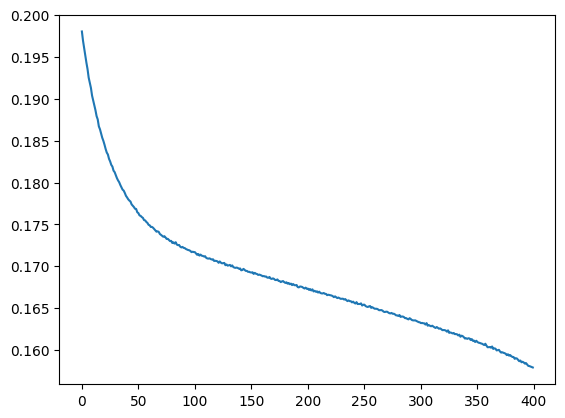

In [ ]:
plt.plot(loss_list)

In [ ]:
# Initialize Pygame
pygame.init()

# Set the window dimensions
window_size = (1000, 1000)

# Create a window
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Particle Simulation")

# Define colors
bg_color = (138, 175, 255)
dot_color = (255, 255, 255)

# Function to map PyTorch tensor positions to screen coordinates
def map_to_screen(position, max_position):
    x, y = position.detach().cpu().numpy()
    x = int((x / max_position + 1) * window_size[0] / 2)
    y = int((y / max_position + 1) * window_size[1] / 2)
    return x, y

# Main game loop
running = True

vectors = torch.zeros(world.shape, dtype=torch.float32, device=GPU)
max_position = float(torch.max(torch.abs(world)))

while running:
    if float(torch.max(torch.abs(world))) >= max_position:
        max_position = float(torch.max(torch.abs(world)))
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Clear the screen
    screen.fill(bg_color)

    # Update your PyTorch world (you'll need to adapt this part)
    vectors = get_network_global_vectors(world, vectors)
    world += vectors

    # Draw dots on the screen based on your PyTorch world
    for position in world:
        pygame.draw.circle(screen, dot_color, map_to_screen(position, max_position), 5)  # 5 is the radius of the dot
    #pygame.draw.circle(screen, (116, 255, 56), map_to_screen(torch.tensor([0, 0]), max_position), 5)  # 5 is the radius of the dot

    # Update the display
    pygame.display.flip()

# Quit Pygame
pygame.quit()
sys.exit()

In [47]:
import re

In [48]:
def remove_from_str(string, remove_characters):
    for x in remove_characters:
        string = string.replace(x, "")
    return string

In [64]:
def extract_vars(line, invalid):
    line = line.split("=")[1]
    return list(set(re.sub(r'\s+', ' ', remove_from_str(line, "+=-*/%()1234567890.<>")).strip().split(" ")) + invalid)

In [65]:
calculation = """test = hate_niggers * 2.4 / amogus_skibidi_toilet
sex_furry_porn = test + 1"""

display_name = "sex_furry_porn"

if "." in calculation:
    dtype = "double"
else:
    dtype = "int"

variables = []

for x in calculation.split("\n"):
    variables += extract_vars(x, )

TypeError: extract_vars() missing 1 required positional argument: 'invalid'

In [63]:
variables

['amogus_skibidi_toilet', 'hate_niggers', 'test']

In [58]:
input_text_block = ""

for x in variables:
    input_text_block += f"            {x} = int.Parse(Console.ReadLine());\n"

In [59]:
print(input_text_block)

            amogus_skibidi_toilet = int.Parse(Console.ReadLine());
            hate_niggers = int.Parse(Console.ReadLine());



In [28]:
template_insertion = f'''using System;\nnamespace test\n[OPEN_BRACKET]\nclass Program\n    [OPEN_BRACKET]\n        static void Main(String[] args)\n        [OPEN_BRACKET]\n            {dtype} {", ".join(variables)}, {display_name};\n            Console.WriteLine("write: {", ".join(variables)}:");\n\n{input_text_block}\n            {display_name} = {calculation};\n\n            Console.WriteLine("{display_name.replace("_", " ")}: " + {display_name});\n\n        [CLOSE_BRACKET]\n    [CLOSE_BRACKET]\n[CLOSE_BRACKET]'''

In [29]:
print(template_insertion.replace("[CLOSE_BRACKET]", "}").replace("[OPEN_BRACKET]", "{"))

using System;
namespace test
{
class Program
    {
        static void Main(String[] args)
        {
            double amogus_skibidi_toilet, hate_niggers, sex_furry_porn;
            Console.WriteLine("write: amogus_skibidi_toilet, hate_niggers:");

            amogus_skibidi_toilet = int.Parse(Console.ReadLine());
            hate_niggers = int.Parse(Console.ReadLine());

            sex_furry_porn = hate_niggers * 2.4 / amogus_skibidi_toilet;

            Console.WriteLine("sex furry porn: " + sex_furry_porn);

        }
    }
}
